In [42]:
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from statsmodels.tsa.stattools import adfuller

In [5]:
ticker = 'CVX'
start_date = '2000-01-01'
end_date = '2024-01-01'
data = yf.download(ticker, start=start_date, end=end_date)
data = data['Close']
data = data['CVX']
data = data.bfill()
print(data.head())

[*********************100%***********************]  1 of 1 completed

Date
2000-01-03    41.81250
2000-01-04    41.81250
2000-01-05    42.56250
2000-01-06    44.37500
2000-01-07    45.15625
Name: CVX, dtype: float64


In [17]:
order = (4, 1, 1)
train_end_year = 2018
validation_end_year = 2022

In [18]:
train = data[data.index.year <= train_end_year]
validation = data[(data.index.year > train_end_year) & (data.index.year <= validation_end_year)]
test = data[data.index.year > validation_end_year]

train_list = train.to_list()
validation_list = validation.to_list()
test_list = test.to_list()

print(train_list[:5], len(train_list))
print(validation_list[:5], len(validation_list))
print(test_list[:5], len(test_list))

[41.8125, 41.8125, 42.5625, 44.375, 45.15625] 4779
[110.69000244140625, 108.56999969482422, 110.81999969482422, 112.26000213623047, 111.7699966430664] 1008
[173.99000549316406, 172.13999938964844, 175.24000549316406, 176.55999755859375, 175.17999267578125] 250


In [29]:
def show_parameters(pred_val, cfd_val, pred_test, cfd_test):
    val_mape = np.mean(np.abs((validation.to_list() - pred_val) / validation.to_list())) * 100
    test_mape = np.mean(np.abs((test.to_list() - pred_test) / test.to_list())) * 100

    print(f"val_mape: {val_mape}")
    print(f"test_mape: {test_mape}")

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Validation Data
    axes[0].plot(validation, label='Actual Data')
    axes[0].plot(validation.index, pred_val, label='ARIMA Predictions')
    axes[0].fill_between(
        validation.index,
        [i[0] for i in cfd_val],[i[1] for i in cfd_val],
        color='pink', alpha=0.3
    )
    axes[0].set_title('Validation Data')
    axes[0].set_xlabel('Time Steps')
    axes[0].set_ylabel('Values')

    # Test Data
    axes[1].plot(test, label='Actual Data')
    axes[1].plot(test.index, pred_test, label='ARIMA Predictions')
    axes[1].fill_between(
        test.index,
        [i[0] for i in cfd_test],[i[1] for i in cfd_test],
        color='pink', alpha=0.3
    )
    axes[1].set_title('Test Data')
    axes[1].set_xlabel('Time Steps')
    axes[1].set_ylabel('Values')

    plt.tight_layout()
    plt.show()

In [36]:
# regular implementation

# validation
model = ARIMA(train_list, order=order)
model_fit = model.fit()
results = model_fit.get_forecast(steps=len(validation_list))
reg_val_mean = results.predicted_mean
reg_val_cfd = results.conf_int()

#test
model_fit = ARIMA(train_list + validation_list, order=order).fit()
results = model_fit.get_forecast(steps=len(test_list))
reg_test_mean = results.predicted_mean
reg_test_cfd = results.conf_int()

val_mape: 61.5365448503264
test_mape: 12.514394414602497


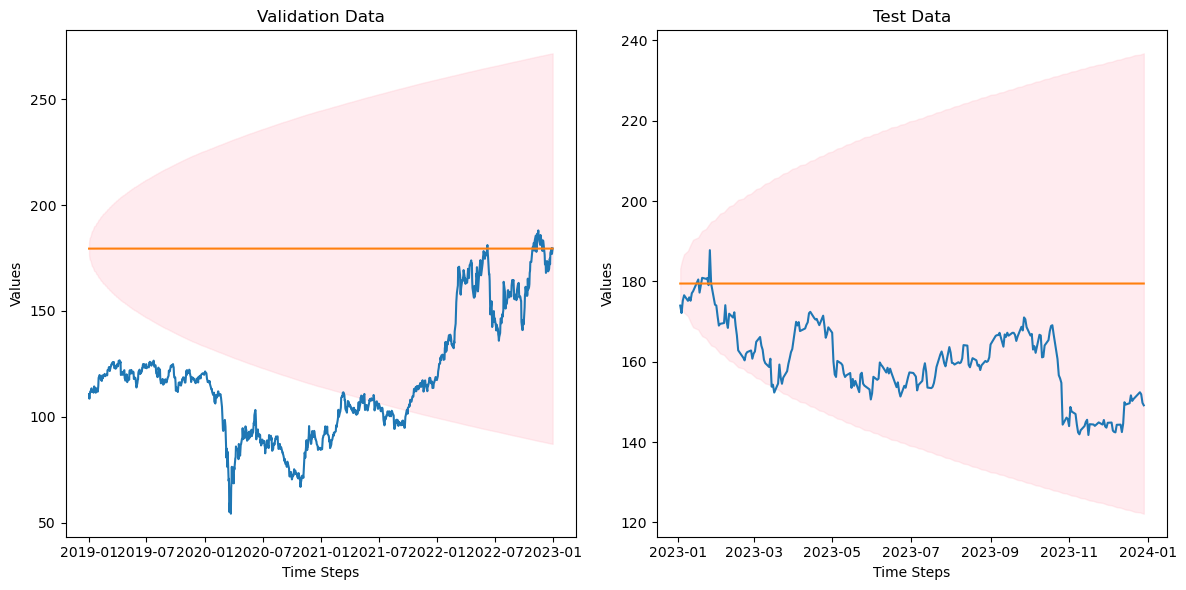

In [37]:
show_parameters(reg_val_mean, reg_val_cfd, reg_test_mean, reg_test_cfd)

In [ ]:
# walk forward implementation
history = train_list
wf_val_mean = []
wf_val_cfd = []


for t in tqdm(range(len(validation_list))):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    next_day = model_fit.get_forecast(steps=1) 
    wf_val_mean.append(next_day.predicted_mean)
    wf_val_cfd.append(next_day.conf_int())
    history.append(validation.iloc[t])

wf_val_mean = np.concatenate(wf_val_mean)
wf_val_cfd = np.concatenate(wf_val_cfd)

results = model_fit.get_forecast(steps=len(test_list))
wf_test_mean = results.predicted_mean
wf_test_cfd = results.conf_int()

100%|██████████| 1008/1008 [22:27<00:00,  1.34s/it]


[[106.49476323 111.38275024]
 [108.12067886 113.01324556]
 [106.25708799 111.14647257]
 ...
 [176.59179865 182.60382617]
 [174.1117121  180.12473284]
 [175.24139332 181.25421605]]
val_mape: 1.530237257612286
test_mape: 11.792845582447859


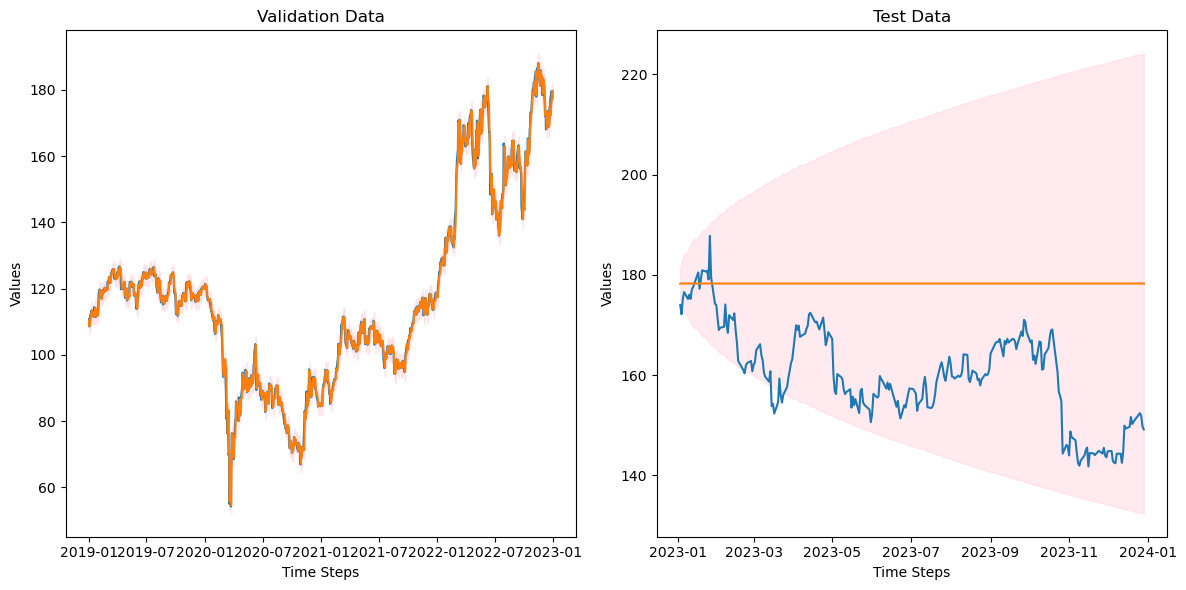

In [ ]:
show_parameters(wf_val_mean, wf_val_cfd, wf_test_mean, wf_test_cfd)

In [ ]:
result = adfuller(data.to_list())
output = {
    "Test Statistic": result[0],
    "p-value": result[1],
    "Lags Used": result[2],
    "Number of Observations Used": result[3],
    "Critical Values": result[4],
    "Stationary?": "Yes" if result[1] < 0.05 else "No"
}
print(output)

{'Test Statistic': np.float64(-1.2764642211692254), 'p-value': np.float64(0.639870007988992), 'Lags Used': 26, 'Number of Observations Used': 6010, 'Critical Values': {'1%': np.float64(-3.4314385349768357), '5%': np.float64(-2.86202103254593), '10%': np.float64(-2.567026051146038)}, 'Stationary?': 'No'}
